# Heart Disease Classifier – Final Project

In [420]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

## 1. Data Loading & Cleaning

Our dataset (https://archive.ics.uci.edu/dataset/45/heart+disease) have 14 features, two of which (ca and thal) have missing values. We checked the dataset and found that 6 rows contain missing values. From here we have two main options to make the dataset usable.

1. **Exclude the 6 incomplete rows:** This is simple and safe. The dataset contains 303 rows, so removing 6 will reduce the size to roughly 98% which most likely wont affect the performance a lot. However, this solution assumes that the missing data have no correlation to the other values.
2. **Fill the missing data using the mean or mode:** For numerical features (like ca), the mean can be used. And for categorical features (like thal), the mode can be used
3. **Predict the missing values:** We could also try to predict the values using regression or KNN

**Our choice:** We choose the first option since it keeps the cleaning process simple and avoids inacurrate assumptions that could affect our results.P

In [421]:
# Load the data
df = pd.read_csv("./heart+disease/processed.cleveland.data", header=None, na_values="?")

# Add column names (from the 14 features)
df.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

# Check for missing values
print(df.isna().sum())

# Drop all the rows that are incomplete
df_clean = df.dropna()

print(f"Original size: {len(df)} rows")
print(f"After dropping missing: {len(df_clean)} rows")
# 6 rows dropped. Seems to check out!

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
Original size: 303 rows
After dropping missing: 297 rows


## 2. Exploratory Data Analysis (EDA)

First, we'll take a look at all the features to see what are numerical and what are categorical. The infromation for the data set says that all of the values are transfered to numerical which is good! But for the PCA and GMM in 3.

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0    0  
1    2.0  3.0   3.0    2  
2    2.0  2.0   7.0    1  
3    3.0  0.0   3.0    0  
4    1.0  0.0   3.0    0  
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object


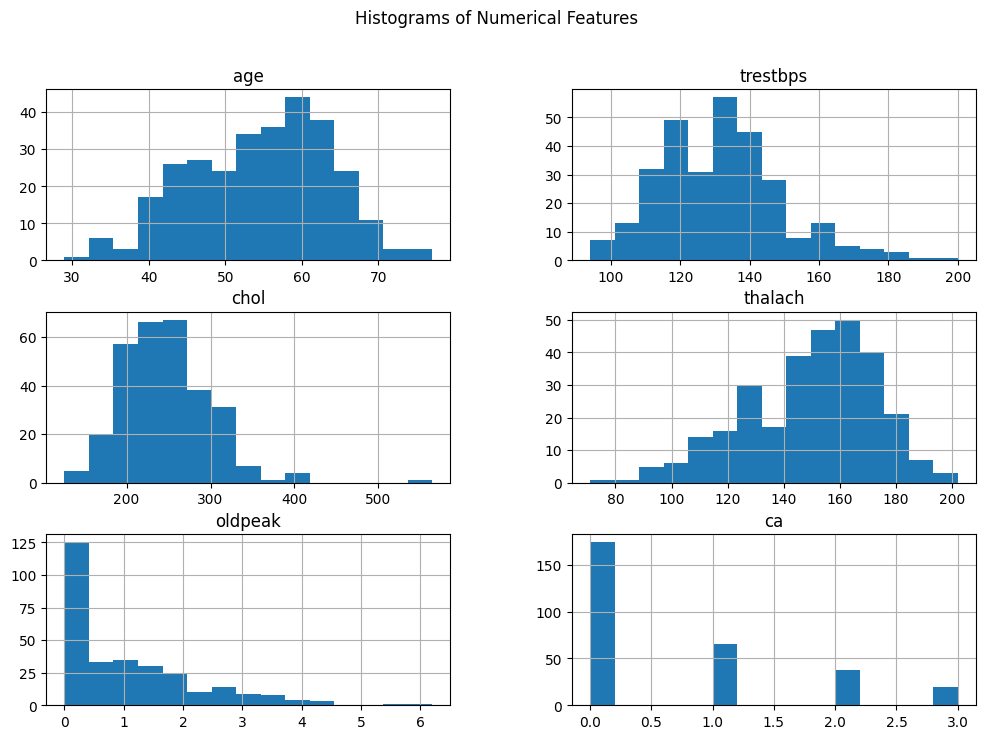

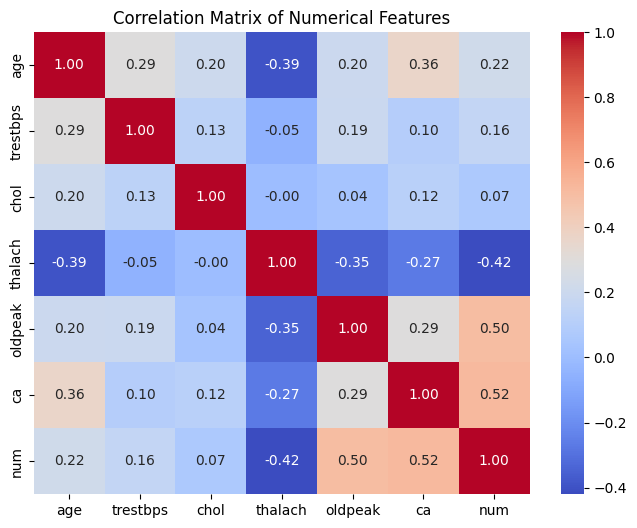

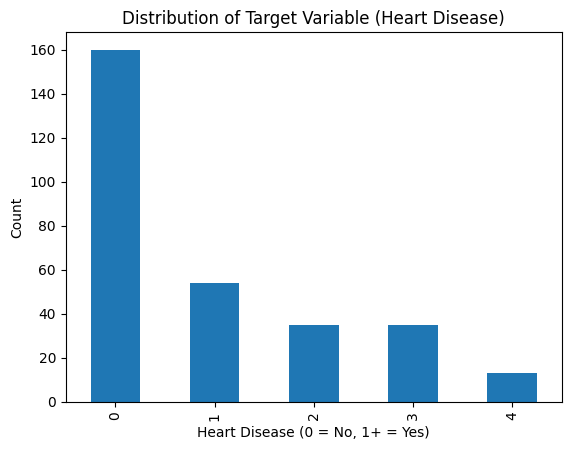

In [422]:
# Preview the first few rows
print(df_clean.head())

# Check data types
print(df_clean.dtypes)

# All the numerical features
numerical_features = [ "age", "trestbps", "chol", "thalach", "oldpeak", "ca", "num" ]
X_numerical = df_clean[numerical_features]
X_unsupervised = X_numerical.drop(columns="num")

# We dont want the labeldata for the unsupervised learning.
X_unsupervised.hist(bins=15, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(X_numerical.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

df_clean["num"].value_counts().plot(kind="bar")
plt.title("Distribution of Target Variable (Heart Disease)")
plt.xlabel("Heart Disease (0 = No, 1+ = Yes)")
plt.ylabel("Count")
plt.show()

## 3. Unsupervised Learning: PCA + GMM

In [423]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

def get_outliers(X_unsupervised_input, k, percentile_threshold):
    X_unsupervised_processed = X_unsupervised_input.copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_unsupervised_processed)

    pca = PCA(n_components=k, random_state=42) # Added random_state for PCA for reproducibility
    X_pca = pca.fit_transform(X_scaled)

    # Increased max_iter to give GMM more chances to converge
    gmm = GaussianMixture(n_components=2, random_state=42, max_iter=300)
    gmm.fit(X_pca)

    log_probs = gmm.score_samples(X_pca)
    
    threshold = np.quantile(log_probs, percentile_threshold)
    outliers = log_probs < threshold

    outlier_feature = pd.Series(outliers, index=X_unsupervised_processed.index, name='is_outlier')

    return outlier_feature.astype(int)

## 4. Supervised Learning: SVM, Random Forest, KNN, Linear Regression

In [424]:
"""function taken from lab 3"""
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    """taken from https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth

    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t\p" + (columnwidth-3)//2 * " "

    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES

    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")

    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [425]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import ClassifierMixin

supervised_models = {}
supervised_model_data = {}

def _evaluate_model(model: ClassifierMixin, model_name: str, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, cv_score_from_grid_search: float) -> dict:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    current_accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    unique_labels = np.unique(y_test)

    # Ensure labels are string-formatted for classification_report dictionary keys
    unique_labels_str = [str(label) for label in unique_labels]

    # Assume '1' is the positive class and '0' is the negative class for heart disease
    positive_class_label_str = '1'
    negative_class_label_str = '0'

    # Robustly determine positive/negative labels if not strictly '0'/'1'
    if len(unique_labels) == 2:
        # If unique_labels are [0, 1] or ['A', 'B'], ensure consistent mapping
        if '1' not in unique_labels_str or '0' not in unique_labels_str:
            # Assign max as positive, min as negative if 0/1 not found
            positive_class_label_str = str(unique_labels.max())
            negative_class_label_str = str(unique_labels.min())
    else:
        raise ValueError(f"Target variable must be binary. Found unique labels: {unique_labels}. Cannot determine positive/negative class.")


    cls_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0, labels=unique_labels)

    precision_positive = cls_report.get(positive_class_label_str, {}).get('precision', 0.0)
    # Recall for the positive class (often called Sensitivity)
    recall_positive = cls_report.get(positive_class_label_str, {}).get('recall', 0.0)
    f1_positive = cls_report.get(positive_class_label_str, {}).get('f1-score', 0.0)

    return {
        'model_object': model,
        'accuracy': current_accuracy,
        'confusion_matrix': cm.tolist(),
        'precision_positive': precision_positive,
        'recall_positive': recall_positive, # This is your Sensitivity
        'f1_positive': f1_positive,
        'cv_score': cv_score_from_grid_search
    }

# --- Helper for KNN Cross-Validation ---
def knn_get_best_k(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    param_grid = {'n_neighbors': range(1, 21)} # Common range for K
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_

# --- Helper for SVM Cross-Validation ---
def svm_get_best_params(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1],
        'kernel': ['rbf', 'linear']
    }
    grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_

# --- Helper for Random Forest Cross-Validation ---
def rf_get_best_n(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200], # Number of trees
        'max_depth': [None, 5, 10] # Max depth of trees
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train) # RF typically does not need scaled data
    
    return grid_search.best_estimator_, grid_search.best_score_

# --- Helper for Logistic Regression Cross-Validation ---
def lr_get_best_params(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'] # 'liblinear' good for small datasets, 'lbfgs' for larger
    }
    grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_

def supervised_learning(X_train, X_test, y_train, y_test):
    all_detailed_metrics = {}
    trained_models = {}

    # Scaling for models sensitive to scale (KNN, SVM, Logistic Regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- KNN Model (CV-optimized) ---
    best_knn_model_cv, best_cv_score_knn = knn_get_best_k(X_train, y_train)

    knn_metrics = _evaluate_model(best_knn_model_cv, "KNN", X_train_scaled, X_test_scaled, y_train, y_test, best_cv_score_knn)

    trained_models["KNN"] = knn_metrics['model_object']
    all_detailed_metrics["KNN"] = {
        'accuracy': knn_metrics['accuracy'],
        'precision_positive': knn_metrics['precision_positive'],
        'recall_positive': knn_metrics['recall_positive'], # This is your Sensitivity
        'f1_positive': knn_metrics['f1_positive'],
        # 'specificity': knn_metrics['specificity'], # REMOVED: No longer expecting this if you removed it from _evaluate_model
        'cv_score': knn_metrics['cv_score']
    }

    # --- SVM Model (CV-optimized) ---
    best_svm_model_cv, best_cv_score_svm = svm_get_best_params(X_train, y_train)

    svm_metrics = _evaluate_model(best_svm_model_cv, "SVM", X_train_scaled, X_test_scaled, y_train, y_test, best_cv_score_svm)

    trained_models["SVM"] = svm_metrics['model_object']
    all_detailed_metrics["SVM"] = {
        'accuracy': svm_metrics['accuracy'],
        'precision_positive': svm_metrics['precision_positive'],
        'recall_positive': svm_metrics['recall_positive'], # This is your Sensitivity
        'f1_positive': svm_metrics['f1_positive'],
        # 'specificity': svm_metrics['specificity'], # REMOVED
        'cv_score': svm_metrics['cv_score']
    }

    # --- Random Forest Model (CV-optimized) ---
    best_rf_model_cv, best_cv_score_rf = rf_get_best_n(X_train, y_train)

    rf_metrics = _evaluate_model(best_rf_model_cv, "Random Forest", X_train, X_test, y_train, y_test, best_cv_score_rf) # RF doesn't need scaling

    trained_models["Random Forest"] = rf_metrics['model_object']
    all_detailed_metrics["Random Forest"] = {
        'accuracy': rf_metrics['accuracy'],
        'precision_positive': rf_metrics['precision_positive'],
        'recall_positive': rf_metrics['recall_positive'], # This is your Sensitivity
        'f1_positive': rf_metrics['f1_positive'],
        # 'specificity': rf_metrics['specificity'], # REMOVED
        'cv_score': rf_metrics['cv_score']
    }

    # --- Logistic Regression Model (CV-optimized) ---
    best_lr_model_cv, best_cv_score_lr = lr_get_best_params(X_train, y_train)

    lr_metrics = _evaluate_model(best_lr_model_cv, "Logistic Regression", X_train_scaled, X_test_scaled, y_train, y_test, best_cv_score_lr)

    trained_models["Logistic Regression"] = lr_metrics['model_object']
    all_detailed_metrics["Logistic Regression"] = {
        'accuracy': lr_metrics['accuracy'],
        'precision_positive': lr_metrics['precision_positive'],
        'recall_positive': lr_metrics['recall_positive'], # This is your Sensitivity
        'f1_positive': lr_metrics['f1_positive'],
        # 'specificity': lr_metrics['specificity'], # REMOVED
        'cv_score': lr_metrics['cv_score']
    }

    # --- Final Summary Prints (Minimal) ---
    print("\nSummary of Accuracies:")
    for name, metrics in all_detailed_metrics.items():
        print(f"- {name}: Acc={metrics.get('accuracy', np.nan):.4f}, CV_Score={metrics.get('cv_score', np.nan):.4f}")

    return all_detailed_metrics, trained_models


In [426]:
def define_input(split, df_clean_original):
    all_experiment_metrics = {}
    all_experiment_models = {}

    percentiles = np.arange(0.05, 0.55, 0.05) # This range correctly includes 0.05 up to 0.50

    # --- 1. Run for "No Outliers" ---
    # This will be treated as k=0 for a special column on your heatmap
    # And there's no percentile threshold as no outliers are removed.
    print("\n--- Running experiment for No Outliers (Baseline) ---")
    df_clean_local_no_outliers = df_clean_original.copy()
    
    # In this case, we do NOT add an 'is_outlier' column derived from GMM/PCA.
    # The dataframe goes directly to dummy encoding and splitting.
    
    categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
    df_final_no_outliers = pd.get_dummies(df_clean_local_no_outliers, columns=categorical_cols, drop_first=True)
    
    X_no_outliers = df_final_no_outliers.drop(columns=["num"])
    y_no_outliers = (df_final_no_outliers["num"] > 0).astype(int) 
    
    X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
        X_no_outliers, 
        y_no_outliers,
        test_size=split,
        random_state=42, 
        stratify=y_no_outliers
    )
    
    print(f"Features (X) shape for No Outliers: {X_no_outliers.shape}")
    print(f"Train/Test Split for No Outliers: X_train {X_train_no_outliers.shape}, X_test {X_test_no_outliers.shape}")

    current_detailed_metrics_no_outliers, current_trained_models_no_outliers = \
        supervised_learning(X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)
    
    # Use a specific key for the "No Outliers" case, e.g., (0, 0.0) or ('No Outliers', 'N/A')
    # Using (0, 0.0) allows it to fit numerically in a heatmap column if you desire.
    all_experiment_metrics[(0, 0.0)] = current_detailed_metrics_no_outliers
    all_experiment_models[(0, 0.0)] = current_trained_models_no_outliers

    # --- 2. Run for Outlier Scenarios (k=1 to 7) ---
    for k in range(1, 8):  # k: PCA components (1 to 7)
        for bottom_percentile in percentiles: # bottom_percentile: 0.05, 0.10, ..., 0.50
            print(f"\n--- Running experiment for PCA components: {k}, Outlier Threshold: {bottom_percentile:.2f} ---")
            
            df_clean_local = df_clean_original.copy() 
            
            # Pass ONLY the numerical features (excluding the target 'num') to get_outliers
            X_unsupervised_features = df_clean_original.select_dtypes(include=np.number).drop(columns=['num'], errors='ignore')
            is_outlier_series = get_outliers(X_unsupervised_features, k, bottom_percentile)
            df_clean_local['is_outlier'] = is_outlier_series # Add the new 'is_outlier' feature
            
            categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
            df_final = pd.get_dummies(df_clean_local, columns=categorical_cols, drop_first=True)
            
            X = df_final.drop(columns=["num"]) 
            y = (df_final["num"] > 0).astype(int) 
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, 
                y,
                test_size=split,
                random_state=42, # Crucial for reproducibility
                stratify=y
            )
            
            print(f"Features (X) shape for this run: {X.shape}")
            print(f"Train/Test Split: X_train {X_train.shape}, X_test {X_test.shape}")

            current_detailed_metrics, current_trained_models = supervised_learning(X_train, X_test, y_train, y_test)
            
            key = (k, round(bottom_percentile, 2)) 
            all_experiment_metrics[key] = current_detailed_metrics
            all_experiment_models[key] = current_trained_models
            
    return all_experiment_metrics, all_experiment_models

In [427]:

all_results_by_split = {}
all_trained_models_by_split = {}
test_sizes = [0.2, 0.3, 0.4]

for test_size in test_sizes:
    print(f"\n--- Running experiments for test_size = {test_size} ---")
    current_metrics_for_heatmap, current_models_trained = define_input(test_size, df_clean)
    
    all_results_by_split[test_size] = current_metrics_for_heatmap 

    all_trained_models_by_split[test_size] = current_models_trained
    
    print(f"Experiments for test_size = {test_size} completed!")

print("\nAll experiments across splits completed!")


--- Running experiments for test_size = 0.2 ---

--- Running experiment for No Outliers (Baseline) ---
Features (X) shape for No Outliers: (297, 18)
Train/Test Split for No Outliers: X_train (237, 18), X_test (60, 18)

Summary of Accuracies:
- KNN: Acc=0.8333, CV_Score=0.8306
- SVM: Acc=0.8667, CV_Score=0.8304
- Random Forest: Acc=0.8167, CV_Score=0.8349
- Logistic Regression: Acc=0.8333, CV_Score=0.8305

--- Running experiment for PCA components: 1, Outlier Threshold: 0.05 ---
Features (X) shape for this run: (297, 19)
Train/Test Split: X_train (237, 19), X_test (60, 19)

Summary of Accuracies:
- KNN: Acc=0.8167, CV_Score=0.8306
- SVM: Acc=0.8667, CV_Score=0.8304
- Random Forest: Acc=0.8500, CV_Score=0.8307
- Logistic Regression: Acc=0.8333, CV_Score=0.8348

--- Running experiment for PCA components: 1, Outlier Threshold: 0.10 ---
Features (X) shape for this run: (297, 19)
Train/Test Split: X_train (237, 19), X_test (60, 19)

Summary of Accuracies:
- KNN: Acc=0.8167, CV_Score=0.8265



--- Generating Heatmaps for Test Size: 0.2 ---


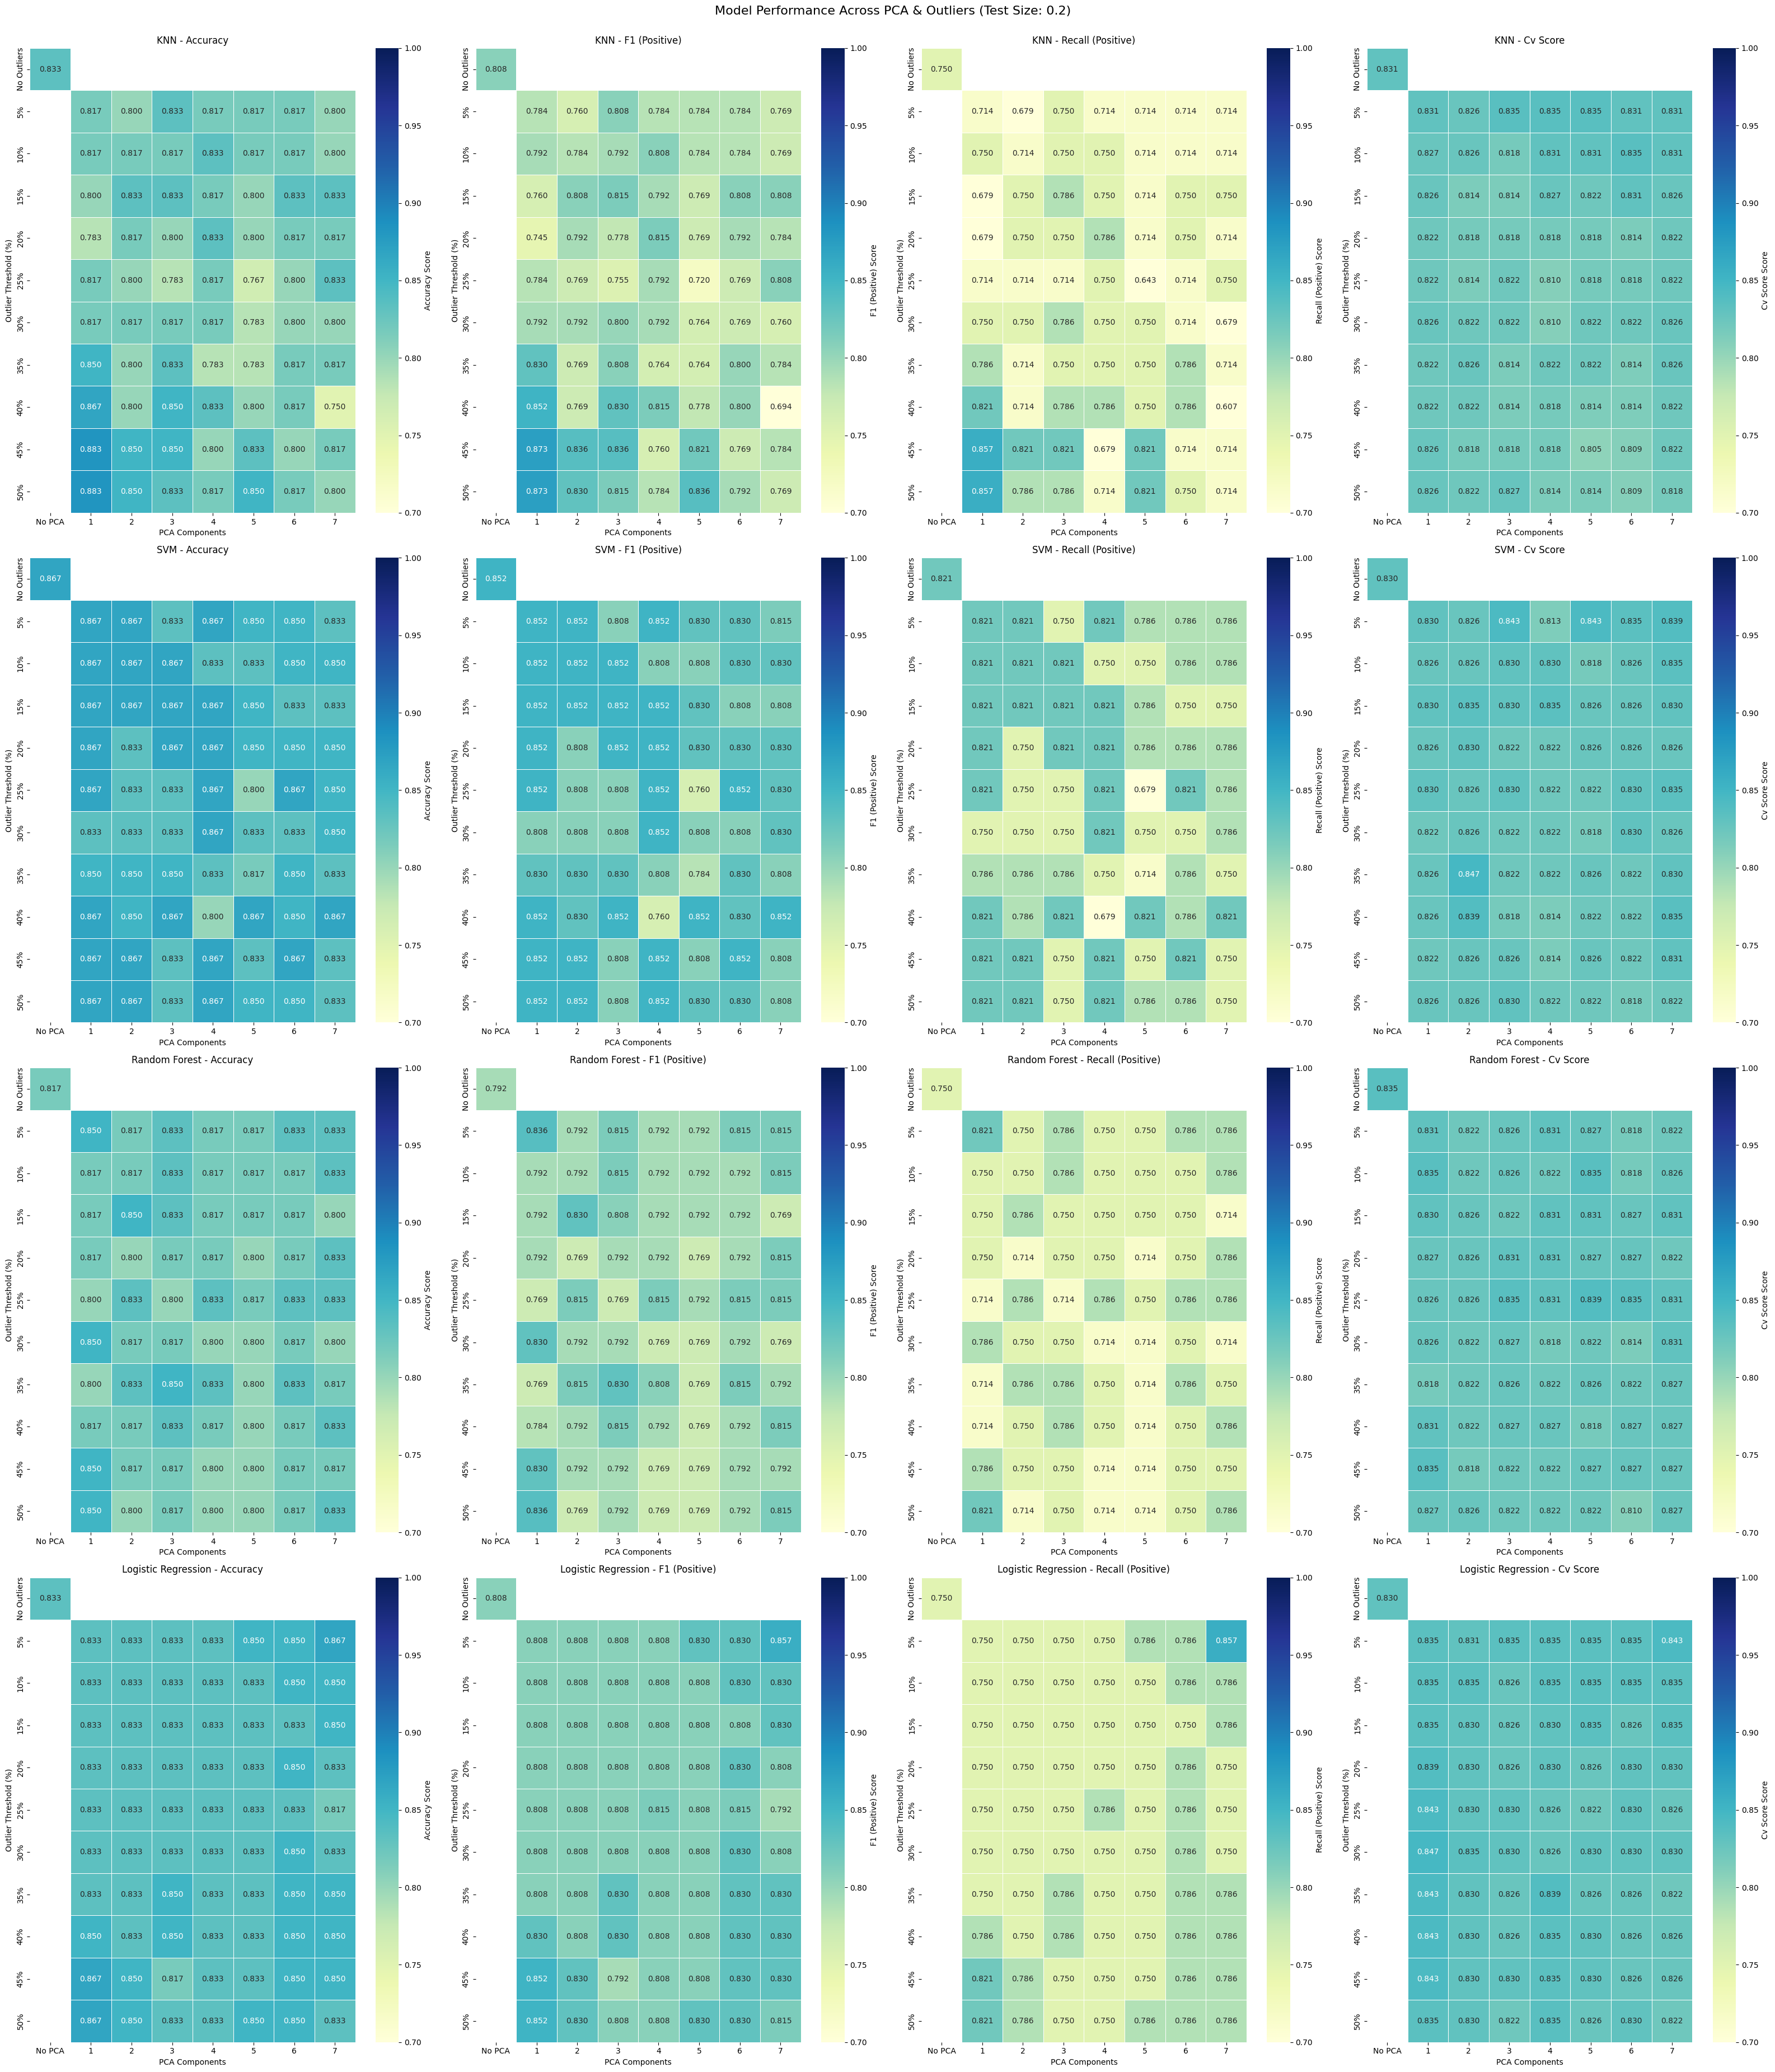


--- Generating Heatmaps for Test Size: 0.3 ---


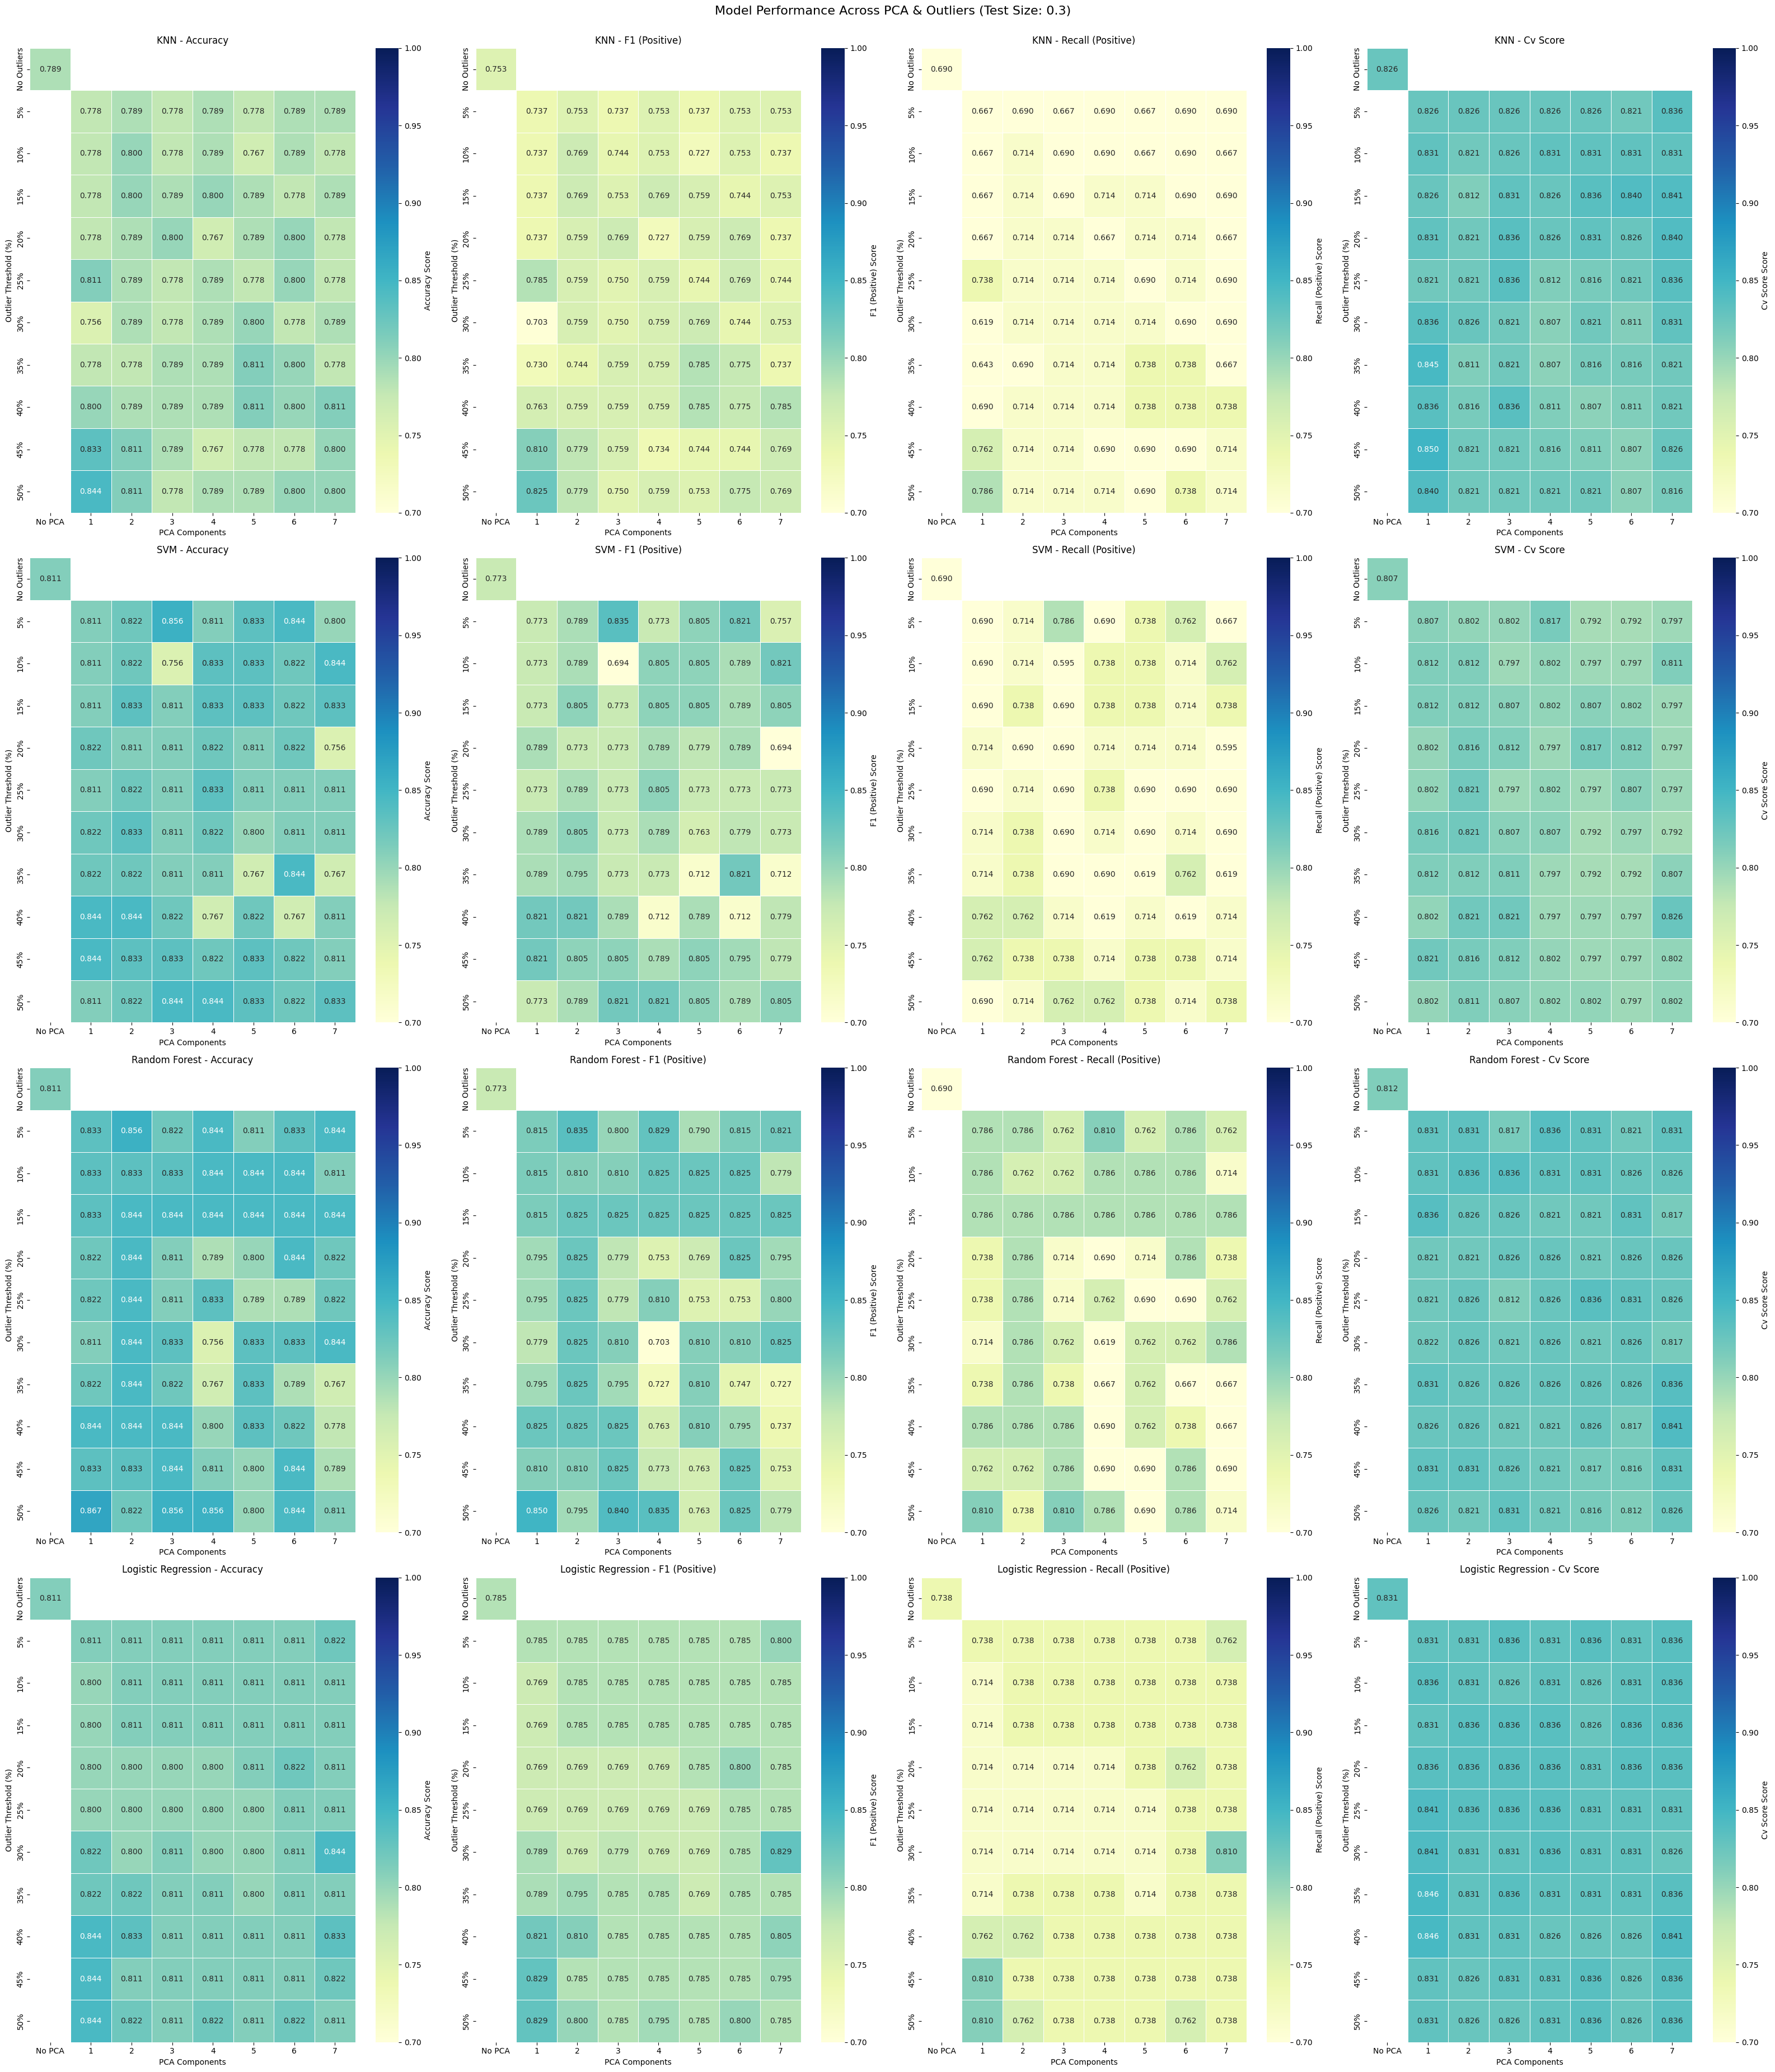


--- Generating Heatmaps for Test Size: 0.4 ---


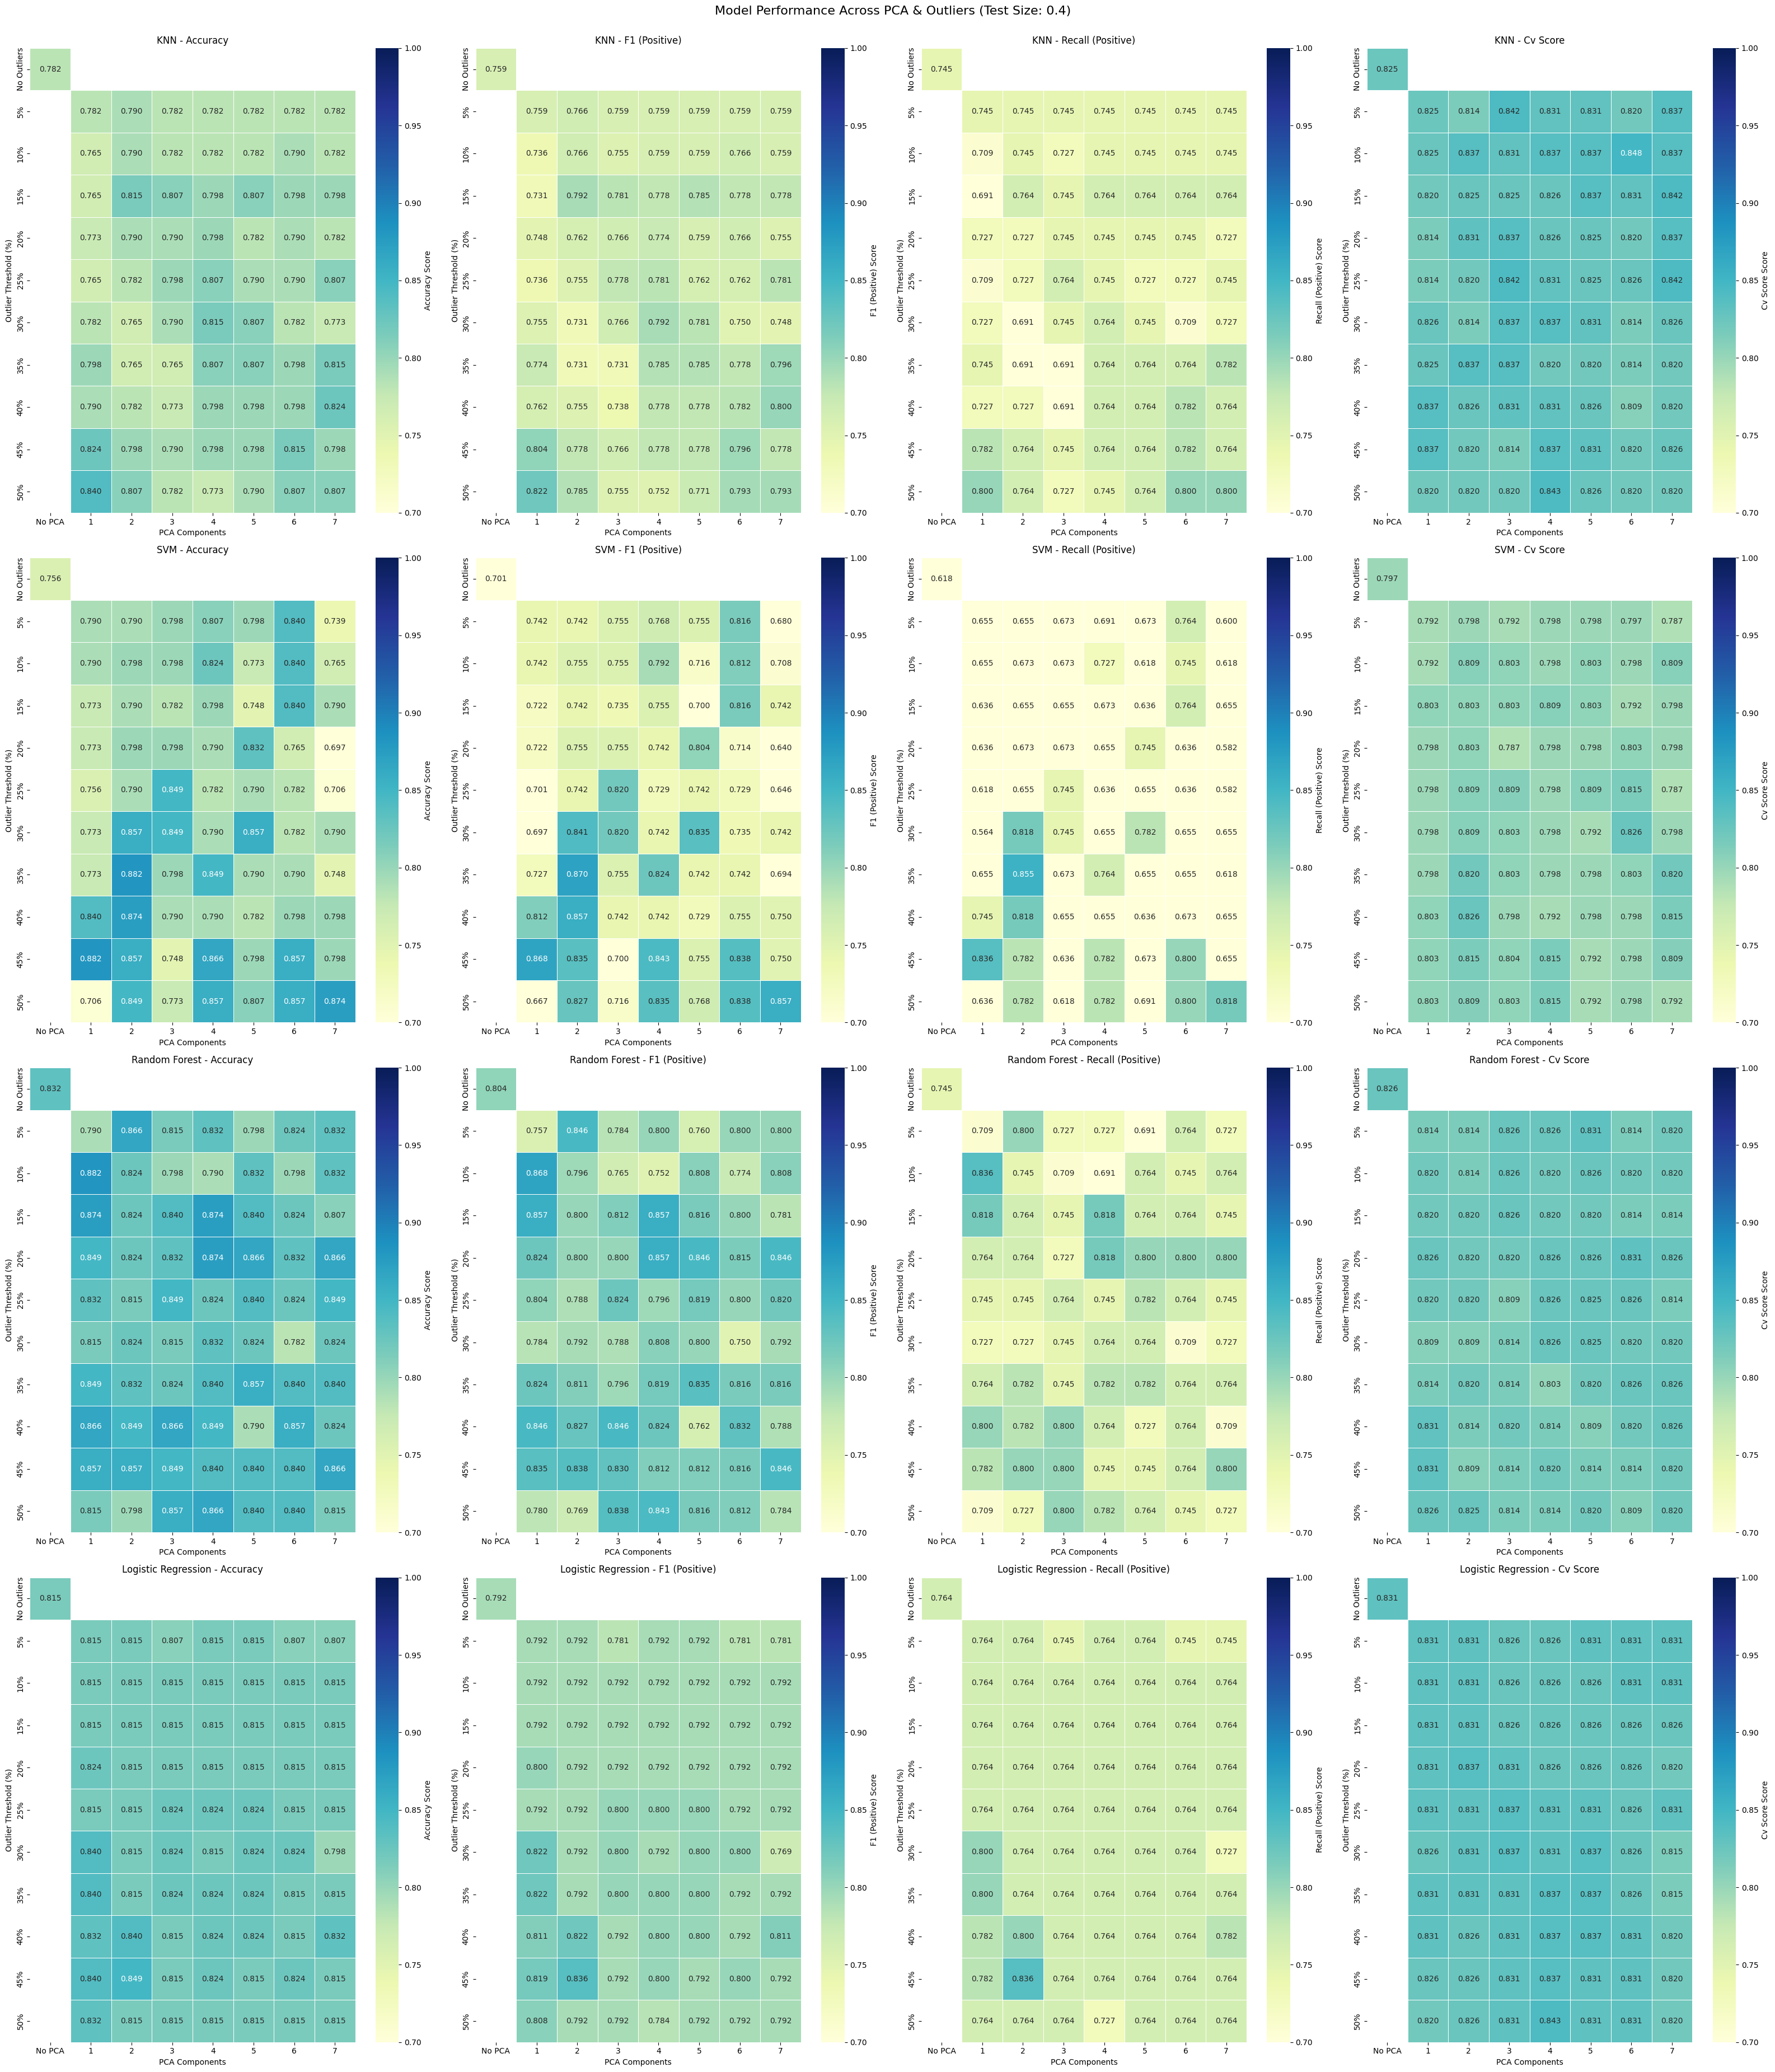


All sets of heatmaps generated successfully!


In [428]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# --- DUMMY DATA (REMOVE OR COMMENT OUT WHEN USING YOUR ACTUAL DATA) ---
# This dummy data should now be structured to represent results for multiple test_sizes
# If you are not using your actual define_input, ensure this dummy data
# reflects the structure of all_results_by_split, e.g., nested dictionary.

# --- 2. Define Heatmap Configuration (remains largely the same) ---
models_to_plot = ["KNN", "SVM", "Random Forest", "Logistic Regression"]
metrics_to_plot = ["accuracy", "f1_positive", "recall_positive", "cv_score"]

percentile_values = np.arange(0.05, 0.55, 0.05)
row_labels = [f"{int(p*100)}%" for p in percentile_values]
row_labels.insert(0, "No Outliers")

pca_k_values = range(1, 8)
column_labels = [str(k) for k in pca_k_values]
column_labels.insert(0, "No PCA")


# --- 3. Generate and Display Heatmaps for EACH Split ---

# We will now loop through each test_size's results
for test_size, all_metrics_for_heatmap_current_split in all_results_by_split.items():
    print(f"\n--- Generating Heatmaps for Test Size: {test_size} ---")

    # This dictionary will hold DataFrames for the current split's heatmaps.
    heatmap_dataframes = {}

    for model_name in models_to_plot:
        for metric_name in metrics_to_plot:
            df_current_heatmap = pd.DataFrame(index=row_labels, columns=column_labels, dtype=float)

            for k_val in range(0, 8):
                for p_val_raw in list(percentile_values) + [0.0]:
                    
                    if k_val == 0 and p_val_raw == 0.0:
                        dict_key = (0, 0.0)
                        df_row_idx = "No Outliers"
                        df_col_idx = "No PCA"
                    elif k_val > 0 and p_val_raw > 0.0:
                        dict_key = (k_val, round(p_val_raw, 2))
                        df_row_idx = f"{int(p_val_raw*100)}%"
                        df_col_idx = str(k_val)
                    else:
                        continue 

                    # Fetch the metric value from the current split's data
                    value = all_metrics_for_heatmap_current_split.get(dict_key, {}).get(model_name, {}).get(metric_name, np.nan)
                    df_current_heatmap.loc[df_row_idx, df_col_idx] = value

            heatmap_dataframes[f"{model_name}_{metric_name}"] = df_current_heatmap

    # --- 4. Generate and Display Heatmaps for the CURRENT Split ---
    num_rows = len(models_to_plot)
    num_cols = len(metrics_to_plot)

    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        figsize=(4 * len(column_labels) * num_cols / (num_cols if num_cols > 0 else 1) ,
                 3.5 * len(row_labels) * num_rows / (num_rows if num_rows > 0 else 1) )
    )

    axes = axes.ravel() # Flatten for easy iteration

    plot_idx = 0
    for model_name in models_to_plot:
        for metric_name in metrics_to_plot:
            plot_key = f"{model_name}_{metric_name}"
            df_heatmap = heatmap_dataframes.get(plot_key)

            if df_heatmap is not None:
                ax = axes[plot_idx]
                sns.heatmap(
                    df_heatmap,
                    annot=True,
                    fmt=".3f",
                    cmap="YlGnBu",
                    linewidths=.5,
                    cbar_kws={'label': f"{metric_name.replace('_positive', ' (Positive)').replace('_', ' ').title()} Score"},
                    vmin=0.7,   # Set min value for color bar to 0.7 for better contrast
                    vmax=1,     # Set max value for color bar to 1
                    ax=ax
                )
                ax.set_title(f"{model_name} - {metric_name.replace('_positive', ' (Positive)').replace('_', ' ').title()}", fontsize=12)
                ax.set_xlabel("PCA Components")
                ax.set_ylabel("Outlier Threshold (%)")
                
                plot_idx += 1

    # Remove any unused subplots
    while plot_idx < len(axes):
        fig.delaxes(axes[plot_idx])
        plot_idx += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    # Add a super title that includes the current test_size
    plt.suptitle(f"Model Performance Across PCA & Outliers (Test Size: {test_size})", fontsize=16, y=0.99)
    plt.show()

print("\nAll sets of heatmaps generated successfully!")

## 5. Feature Importance


--- Overall Best Model Summary ---
Best Test Size: 0.2
Best Outlier Scenario (PCA components, Percentile): (1, np.float64(0.45))
Best Model: KNN
Best Score (F1-positive): 0.8727

--- Feature Importance for KNN (Best Model) ---

KNN Permutation Importance:
sex_1.0: 0.0317
is_outlier: 0.0217
oldpeak: 0.0167
cp_4.0: 0.0117
thalach: 0.0100
ca: 0.0067
exang_1.0: 0.0050
trestbps: 0.0050
thal_7.0: 0.0050
slope_2.0: 0.0017


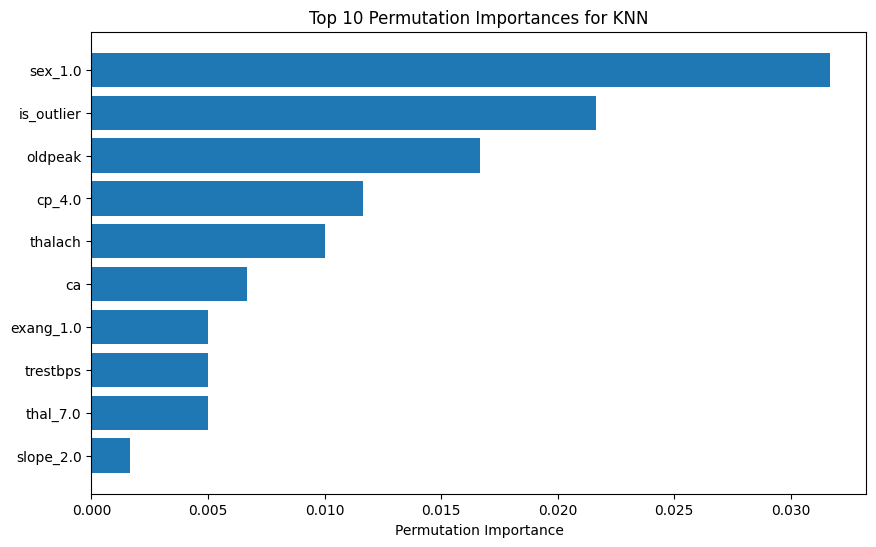

In [429]:
best_overall_score = -1.0 # Initialize with a very low score
best_overall_test_size = None
best_overall_outlier_scenario = None # This will be (k, percentile)
best_overall_model_name = None

for test_size, scenario_metrics in all_results_by_split.items():
    for scenario_key, model_metrics_dict in scenario_metrics.items():
        for model_name, metrics in model_metrics_dict.items():
            current_score = metrics.get('f1_positive', -1.0) # Using f1_positive as the key metric
            if current_score > best_overall_score:
                best_overall_score = current_score
                best_overall_test_size = test_size
                best_overall_outlier_scenario = scenario_key
                best_overall_model_name = model_name

print(f"\n--- Overall Best Model Summary ---")
print(f"Best Test Size: {best_overall_test_size}")
print(f"Best Outlier Scenario (PCA components, Percentile): {best_overall_outlier_scenario}")
print(f"Best Model: {best_overall_model_name}")
print(f"Best Score (F1-positive): {best_overall_score:.4f}")

# --- 2. Retrieve the Best Model Object and Corresponding Data ---
# You need to re-generate the X_train/X_test for the best scenario
# This involves replicating the data processing logic from define_input for the best_overall_outlier_scenario

k_best = best_overall_outlier_scenario[0]
percentile_best = best_overall_outlier_scenario[1]

df_clean_local_best = df_clean.copy() # Use the original clean dataframe

if k_best == 0: # 'No Outliers' case
    # No outlier removal/addition of 'is_outlier' column
    pass
else:
    X_unsupervised_features_best = df_clean.select_dtypes(include=np.number).drop(columns=['num'], errors='ignore')
    is_outlier_series_best = get_outliers(X_unsupervised_features_best, k_best, percentile_best)
    df_clean_local_best['is_outlier'] = is_outlier_series_best

categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
df_final_best = pd.get_dummies(df_clean_local_best, columns=categorical_cols, drop_first=True)

X_best = df_final_best.drop(columns=["num"])
y_best = (df_final_best["num"] > 0).astype(int)

X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X_best,
    y_best,
    test_size=best_overall_test_size,
    stratify=y_best
)

# Retrieve the actual trained model object
best_model_object = all_trained_models_by_split[best_overall_test_size][best_overall_outlier_scenario][best_overall_model_name]
# --- 3. Perform Feature Importance for the Best Model ---

print(f"\n--- Feature Importance for {best_overall_model_name} (Best Model) ---")

# Apply scaling if the best model is scale-sensitive (KNN, SVM, LR)
# Check the model type to apply scaling appropriately for permutation_importance
if isinstance(best_model_object, (KNeighborsClassifier, SVC, LogisticRegression)):
    scaler_best_model = StandardScaler()
    X_train_best_scaled = scaler_best_model.fit_transform(X_train_best)
    X_test_best_scaled = scaler_best_model.transform(X_test_best)
else: # For Random Forest, no scaling needed
    X_train_best_scaled = X_train_best # Use original data
    X_test_best_scaled = X_test_best   # Use original data

if isinstance(best_model_object, RandomForestClassifier):
    # Random Forest Feature Importance (built-in)
    importances = best_model_object.feature_importances_
    features_df = pd.DataFrame({'Feature': X_train_best.columns, 'Importance': importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)

    print(f"\n{best_overall_model_name} Feature Importance (built-in):")
    for i, row in features_df.head(10).iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.barh(features_df['Feature'].head(10), features_df['Importance'].head(10))
    plt.xlabel("Feature Importance")
    plt.title(f"Top 10 Feature Importances for {best_overall_model_name}")
    plt.gca().invert_yaxis()
    plt.show()

elif isinstance(best_model_object, (KNeighborsClassifier, SVC, LogisticRegression)):
    # Permutation Importance for other models (SVM, KNN, Logistic Regression)
    # Using scaled data for models that need it.
    result = permutation_importance(best_model_object, X_test_best_scaled, y_test_best, n_repeats=10, random_state=42, n_jobs=-1)

    sorted_idx = result.importances_mean.argsort()[::-1]
    features_df = pd.DataFrame({'Feature': X_train_best.columns[sorted_idx], 'Importance': result.importances_mean[sorted_idx]})

    print(f"\n{best_overall_model_name} Permutation Importance:")
    for i, row in features_df.head(10).iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.barh(features_df['Feature'].head(10), features_df['Importance'].head(10))
    plt.xlabel("Permutation Importance")
    plt.title(f"Top 10 Permutation Importances for {best_overall_model_name}")
    plt.gca().invert_yaxis()
    plt.show()

else:
    print(f"Feature importance not implemented for model type: {type(best_model_object)}")


## 6. Evaluation: Accuracy, F1, Confusion Matrix


## 7. Conclusions & Discussion